In [18]:
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle

### GLOBAL CONFIG

In [19]:


PREPROCESS = False # Do a fresh preprocess
MAKE_NEW_EMBEDDING = True # If False, the stored one will be loaded
# EMB_MAX_WORDS = None
EMB_MAX_WORDS = 5000
RANDOM_SEED = 456
SAVE_TRAINED_MODEL = True

PREPROCESS_INPUT = './data/training.1600000.processed.noemoticon.csv'
PREPROCESS_OUTPUT = './data/preprocessed.csv'
GLOVE_FILE = './data/glove.6B.50d.txt'
EMB_PKL = './models/emb_layer.pkl'
MODEL_PKL = './models/model.pkl'


### Preprocess data and store it

In [20]:
from pre import preprocess

if PREPROCESS:
    preprocess(i=PREPROCESS_INPUT, o=PREPROCESS_OUTPUT, slice=10)

### Load preprocessed data

In [21]:
from parse import load_data
from sklearn.model_selection import train_test_split

data = load_data(PREPROCESS_OUTPUT)
X = data['tweet']
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=RANDOM_SEED)

y_train = tf.keras.utils.to_categorical(y_train, 2)
y_test = tf.keras.utils.to_categorical(y_test, 2)
y_val = tf.keras.utils.to_categorical(y_val, 2)


### Embedding

In [22]:
from keras.preprocessing.text import Tokenizer
from emb import get_keras_embedding_layer


tokenizer = Tokenizer(num_words=EMB_MAX_WORDS, lower=False, split=' ', oov_token="UNK")
if MAKE_NEW_EMBEDDING: 
    emb_layer = get_keras_embedding_layer(GLOVE_FILE, data['tweet'], tokenizer)

    # save emb_layer
    with open(EMB_PKL, 'wb') as output:
        pickle.dump(emb_layer, output, pickle.HIGHEST_PROTOCOL)
else:
    with open(EMB_PKL, 'wb') as input:
        emb_layer = pickle.load(input)

Glove data loaded
Words not found 4


### Model

In [23]:
%load_ext autoreload
%autoreload 2
from TextClassifierModel import build_model_keras


# TODO: check correct arg-assignment for tokenizer
model = build_model_keras(tokenizer, emb_layer)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
building model
init
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      multiple                  3550      
_________________________________________________________________
flatten_4 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 5000)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                320064    
_________________________________________________________________
dense_11 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_12 (Dense)             (None, 256)               33024     
____________

### Train

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  2  4 19 20 21  4 22  6 23 24 25  5 26 27 28
  7 29 30 31]
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Epoch 1/30
1/1 [==============================] - 1s 773ms/step - loss: 2.8140 - accuracy: 0.5000 - val_loss: 2.7261 - val_accuracy: 0.0000e+00
Epoch 2/30
1/1 [==============================] - 0s 45ms/step - loss: 2.6898 - accuracy: 0.6667 - val_loss: 2.5906 - val_accuracy: 0.5000
Epoch 3/30
1/1 [==============================] - 0s 46ms/step - loss: 2.5769 - accuracy: 1.0000 - val_loss: 2.4739 - val_accuracy: 1.0000
Epoch 4/30
1/1 [==============================] - 0s 42ms/step - loss: 2.4637 - accuracy: 0.5000 - val_loss: 2.3778 - val_accuracy: 1.00

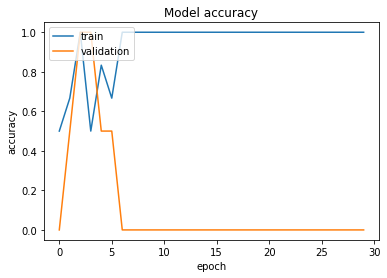

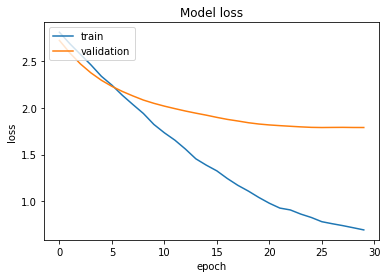

In [24]:
%load_ext autoreload
%autoreload 2
from evaluation import plot_history

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=60, epochs=30, verbose=1)
plot_history(history)

# if SAVE_TRAINED_MODEL:
#     with open(MODEL_PKL, 'wb') as output:
#         pickle.dump(model, output, pickle.HIGHEST_PROTOCOL)

### Load trained model

In [25]:
# with open(MODEL_PKL, 'wb') as input:
#     model = pickle.load(input)

UnsupportedOperation: read

### Evaluate production (forbidden during tuning)

In [27]:
from evaluation import evaluate_model

# evaluate_model(model.model, X_test, y_test)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type list).

### Explain prediction

In [28]:
import eli5
from eli5.lime import TextExplainer

te = TextExplainer(random_state=42)
te.fit("I love candy. I like to be positive, be happy! What a lovely day", model.predict_proba)
te.show_prediction()